# 1. Preparación de entorno






In [ ]:
%pip install --no-cache-dir scikit-learn==1.5.2 kaggle tqdm seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 235.6 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.


In [ ]:
# info de la gpu
!nvidia-smi

# imports
import sys, sklearn
print("Python:", sys.version)
print("scikit-learn:", sklearn.__version__)

import tensorflow as tf
print("TensorFlow:", tf.__version__)

# memory growth + mixed precision
for g in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(g, True)

from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

Tue Nov 18 07:14:14 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   55C    P8             13W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
#imports
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import sys, os, pkg_resources, subprocess
import sklearn
print("TensorFlow:", tf.__version__, "| sklearn:", sklearn.__version__)

TensorFlow: 2.19.0 | sklearn: 1.5.2


/tmp/ipython-input-73389311.py:3: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import sys, os, pkg_resources, subprocess


#2. HAM10000

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir -p "/content/drive/MyDrive/ucsp/implementacion_articulo/IncepX_checkpointsV4"

Mounted at /content/drive


In [ ]:
!unzip -q -o '/content/drive/MyDrive/HAM10000/skin-cancer-mnist-ham10000.zip' -d /content/data

#3. Crear dataframe y mapa de clases

In [ ]:
IMG_DIRS = [
    '/content/data/ham10000_images_part_1',
    '/content/data/ham10000_images_part_2'
]
META_CSV = '/content/data/HAM10000_metadata.csv'

#carga del CSV de metadatos
df = pd.read_csv(META_CSV)
# clases de HAM10000: akiec, bcc, bkl, df, mel, nv, vasc
label_map = {'akiec':0,'bcc':1,'bkl':2,'df':3,'mel':4,'nv':5,'vasc':6}
id2name   = {v:k for k,v in label_map.items()}
df['label'] = df['dx'].map(label_map)

'''
find_path: Busca la ruta de la imagen en IMG_DIRS
  ENTRADA:
    image_id: nombre de la imagen sin extension
  SALIDA:
    ruta de la imagen si la encuentra
'''
def find_path(image_id):
    for d in IMG_DIRS:
        p = f"{d}/{image_id}.jpg"
        if os.path.exists(p): return p
    return None
df['filepath'] = df['image_id'].apply(find_path)
df = df.dropna(subset=['filepath']).reset_index(drop=True)
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,label,filepath
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,2,/content/data/ham10000_images_part_1/ISIC_0027...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,2,/content/data/ham10000_images_part_1/ISIC_0025...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,2,/content/data/ham10000_images_part_1/ISIC_0026...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,2,/content/data/ham10000_images_part_1/ISIC_0025...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,2,/content/data/ham10000_images_part_2/ISIC_0031...


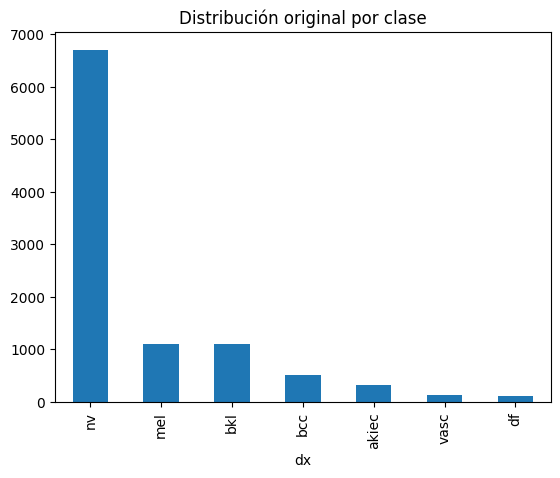

In [ ]:
#distribucion de las clases
df['dx'].value_counts().plot(kind='bar'); plt.title('Distribución original por clase'); plt.show()

In [ ]:
#Split 80/20
'''
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
len(train_df), len(test_df)

SyntaxError: incomplete input (ipython-input-660047118.py, line 2)

#Cargar pesos

In [ ]:
#cargar pesos guardados
import tensorflow as tf

CKPT_DIR = "/content/drive/MyDrive/ucsp/implementacion_articulo/IncepX_checkpointsV4"

inception = tf.keras.models.load_model(f"{CKPT_DIR}/inception_best.keras")
xception  = tf.keras.models.load_model(f"{CKPT_DIR}/xception_best.keras")
concat_model    = tf.keras.models.load_model(f"{CKPT_DIR}/incepx_concat_best.keras")

inception_noAug = tf.keras.models.load_model(f"{CKPT_DIR}/inception_best_noAug.keras")
xception_noAug = tf.keras.models.load_model(f"{CKPT_DIR}/xception_best_noAug.keras")
concat_model_noAug = tf.keras.models.load_model(f"{CKPT_DIR}/incepx_concat_best_noAug.keras")

inception_noAug_ft = tf.keras.models.load_model(f"{CKPT_DIR}/inception_best_noAug_ft.keras")
xception_noAug_ft = tf.keras.models.load_model(f"{CKPT_DIR}/xception_best_noAug_ft.keras")
concat_model_noAug_ft = tf.keras.models.load_model(f"{CKPT_DIR}/incepx_concat_best_noAug_ft.keras")

print("Modelos cargados correctamente")


Modelos cargados correctamente


#4. Redimensionamiento de datos y data augmentation

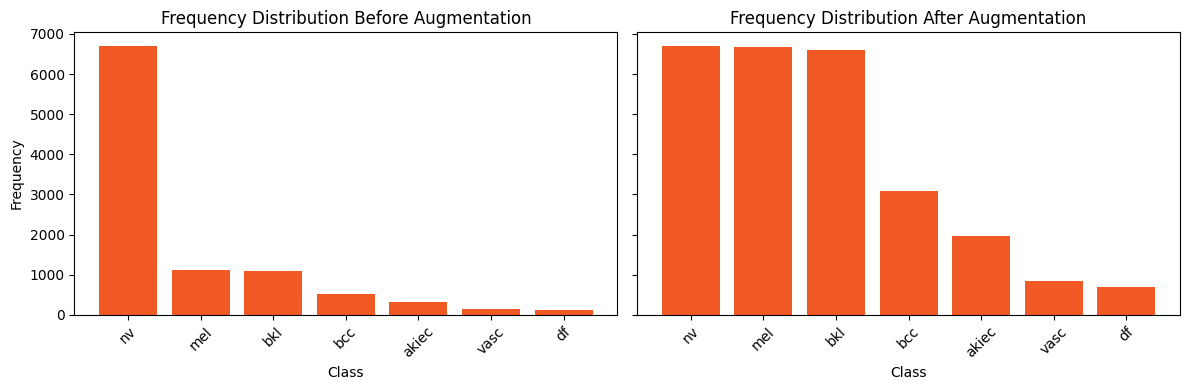

Orden de clases (mayor→menor): ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']
Antes : {'nv': np.int64(6705), 'mel': np.int64(1113), 'bkl': np.int64(1099), 'bcc': np.int64(514), 'akiec': np.int64(327), 'vasc': np.int64(142), 'df': np.int64(115)}
Después: {'nv': np.int64(6705), 'mel': np.int64(6678), 'bkl': np.int64(6594), 'bcc': np.int64(3084), 'akiec': np.int64(1962), 'vasc': np.int64(852), 'df': np.int64(690)}


In [ ]:
# =========================
# CONFIGURACION
# =========================
IMG_SIZE    = 299
AUTOTUNE    = tf.data.AUTOTUNE
NUM_CLASSES = 7
BATCH_SIZE  = 32

SHUF_TRAIN  = 4096
PREFETCH    = 2
TEST_ONLY_ORIGINAL = False   # usar solo originales

import tensorflow as tf, numpy as np, pandas as pd, math, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

label_map = {'akiec':0,'bcc':1,'bkl':2,'df':3,'mel':4,'nv':5,'vasc':6}
id2name   = {v:k for k,v in label_map.items()}

# =========================
# AUMENTACIONES
# =========================
'''
decode_resize: Decodifica jpg a tensor
               Redimensiona a IMG_SIZE (299,299)
  ENTRADA:
    path: ruta al archivo .jpg
  SALIDA:
    tensor (299,299,3)
'''
def decode_resize(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE), method='bilinear')
    return tf.cast(img, tf.float32)/255.0  # [0,1]

'''
apply_variant: aplicar una de las 6 tranforaciones sobre img
  ENTRADA:
    img: tensor (299,299,3)
    variant: tensor escalar [0-5]
  SALIDA:
    tensor img transformado (299,299,3)
'''
def apply_variant(img, variant):
    branch = [
        lambda: img, #original
        lambda: tf.image.rot90(img, 1), # 90°
        lambda: tf.image.rot90(img, 3), # 270°
        lambda: tf.image.rot90(img, 2), # 180°
        lambda: tf.image.flip_left_right(img), # flip izq <-> der
        lambda: tf.image.flip_up_down(img)    # flip arriba <-> abajo
    ]
    return tf.switch_case(variant, branch) # usa lista de funciones lambda

'''
row_to_example: Lee y preprocesa la imagen (decodifica y resize)
                Aplica una de las 6 transformaciones sobre la imagen
                Convierte label a one-hot
  ENTRADA:
    path: ruta al archivo .jpg
    label: tensor escalar [0-6] (indice de clase)
    variant: tensor escalar [0-5] (transformacion a aplicar)
  SALIDA:
    par de tensores (img, label) -> (inputs,targets)
'''
def row_to_example(path, label, variant):
    img = decode_resize(path)          # [0,1]
    img = apply_variant(img, variant)
    # Normalizacion para InceptionV3/Xception [-1,1]
    img = img * 2.0 - 1.0
    y   = tf.one_hot(label, NUM_CLASSES)
    return img, y

# =========================
# CREAR DATAFRAME AUMENTADO
# =========================
'''
make_augmented_index: Crea un dataframe con las 6 variantes de cada imagen
  ENTRADA:
    df_original: dataframe original con columnas almenos ['filepath', 'label']
  SALIDA:
    dataframe con columnas ['filepath', 'label', 'variant']
'''
def make_augmented_index(df_original):
    counts = df_original['label'].value_counts().to_dict() #conteo de filas por clase
    majority_label = max(counts, key=counts.get)

    parts = []
    #Iterar por indice de clase
    for c in range(NUM_CLASSES):
        sub = df_original[df_original['label'] == c]
        if c == majority_label:
            # mayoritaria: solo original
            sub = sub.copy()
            sub['variant'] = 0
            parts.append(sub)
        else:
            # minoritarias: original + 5 variantes
            reps = []
            for v in range(6):
                tmp = sub[['filepath', 'label']].copy()
                tmp['variant'] = v
                reps.append(tmp)
            parts.append(pd.concat(reps, ignore_index=True))
    return pd.concat(parts, ignore_index=True) #concatena mayoritaria y minoritaria

# =========================
# SPLIT 60/20/20 (estratificado)
# =========================
# Cargar el split predefinido del hibrido
split_info = pd.read_csv('/content/drive/MyDrive/ucsp/implementacion_articulo/split_hibrido_60_20_20.csv')
# split_info: columnas ['image_id', 'dx', 'split']

# Unir por image_id, se queda solo lo que hay en disco
df_merged = df.merge(split_info[['image_id', 'split']], on='image_id', how='inner')

# 3 subconjuntos
train_df = df_merged[df_merged['split'] == 'train'].reset_index(drop=True)
val_df   = df_merged[df_merged['split'] == 'val'  ].reset_index(drop=True)
test_df  = df_merged[df_merged['split'] == 'test' ].reset_index(drop=True)

#print("Tamaños Ensemble con split del híbrido:")
#print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))

# =========================
# AUMENTACION POR CONJUNTO
# =========================
train_df_aug = make_augmented_index(train_df)
val_df_aug   = make_augmented_index(val_df)
test_df_aug  = make_augmented_index(test_df)

# para evaluar solo originales en val/test:
if TEST_ONLY_ORIGINAL:
    val_df_aug  = val_df_aug [val_df_aug ['variant']==0].reset_index(drop=True)
    test_df_aug = test_df_aug[test_df_aug['variant']==0].reset_index(drop=True)

# Para graficos
df_aug_all = pd.concat([train_df_aug, val_df_aug, test_df_aug], ignore_index=True)

# =========================
# CREA DATASET tf.data
# =========================
'''
make_ds: Transforma el df en un pipeline de tf para el entrenamiento y validacion
         compatible con model.fit() y model.evaluate()
  ENTRADA:
    df_split: dataframe con columnas ['filepath', 'label', 'variant']
    shuffle:  booleano para shufflear
              True -> mezcla aleatoriamente los ejemplos (training)
              False -> mantiene el orden (test/validacion)
  SALIDA:
    dataset tf.data.Dataset con filas (inputs, targets)
'''
def make_ds(df_split, shuffle=False):
    paths    = df_split['filepath'].values
    labels   = df_split['label'].values.astype(np.int32)
    variants = df_split['variant'].values.astype(np.int32)
    #crear tf.data.Dataset a partir de tres arrays NumPy
    #cada elemento del Dataset es una tupla (p,l,v)
    ds = tf.data.Dataset.from_tensor_slices((paths, labels, variants))
    #usa row_to_example para transformar (p,l,v) a (img,y)
    ds = ds.map(lambda p,l,v: row_to_example(p,l,v), num_parallel_calls=2)
    if shuffle:
        ds = ds.shuffle(SHUF_TRAIN)
    #agrupa ejemplos en batches de 32
    #img: (299,299,3) -> (32,299,299,3)
    #y  : (7,) -> (32,7)
    ds = ds.batch(BATCH_SIZE).prefetch(PREFETCH)
    return ds

train_ds = make_ds(train_df_aug, shuffle=True)   # dataset con shuffle
val_ds   = make_ds(val_df_aug,   shuffle=False)  # dataset sin shuffle
test_ds  = make_ds(test_df_aug,  shuffle=False)  # dataset sin shuffle

val_df_orig = val_df.copy()
test_df_orig = test_df.copy()
val_df_orig['variant'] = 0
test_df_orig['variant'] = 0

val_ds_noAug = make_ds(val_df_orig, shuffle=False)    # dataset sin shuffle ni aug
test_ds_noAug = make_ds(test_df_orig,  shuffle=False)   # dataset sin shuffle ni aug

# =========================
# DISTRIBUCION antes y después
# =========================
before_counts = df['label'].value_counts().reindex(range(NUM_CLASSES), fill_value=0).sort_index()
after_counts  = df_aug_all['label'].value_counts().reindex(range(NUM_CLASSES), fill_value=0).sort_index()

sorted_indices = np.argsort(-after_counts.values)
sorted_labels  = [id2name[i] for i in sorted_indices]

fig, axs = plt.subplots(1, 2, figsize=(12,4), sharey=True)
axs[0].bar(sorted_labels, before_counts.values[sorted_indices], color="#f15a24")
axs[0].set_title("Frequency Distribution Before Augmentation")
axs[0].set_xlabel("Class"); axs[0].set_ylabel("Frequency")
axs[0].tick_params(axis='x', rotation=45)

axs[1].bar(sorted_labels, after_counts.values[sorted_indices], color="#f15a24")
axs[1].set_title("Frequency Distribution After Augmentation")
axs[1].set_xlabel("Class")
axs[1].tick_params(axis='x', rotation=45)
plt.tight_layout(); plt.show()

print("Orden de clases (mayor→menor):", sorted_labels)
print("Antes :", dict(zip(sorted_labels, before_counts.values[sorted_indices])))
print("Después:", dict(zip(sorted_labels, after_counts.values[sorted_indices])))

#5. Modelo concatenado





In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3, Xception

IMG_SIZE = 299
NUM_CLASSES = 7

'''
make_incepX_concat: Modelo concatenado de InceptionV3 y Xception
  ENTRADA:
    dropout:  tasa de Dropout en el cabezal (float entre 0 y 1)
    trainable_backbones: booleano para entrenar backbones
                         False: Congela pesos del backbone
                         True: Permite fine-tuning del backbone
  SALIDA:
    modelo tf.keras.Model listo para compilar/entrenar
'''

def make_incepX_concat(dropout=0.3, trainable_backbones=False):
    inp = layers.Input((IMG_SIZE, IMG_SIZE, 3)) #Tensor a ser consumido por los backbones (299,299,3)

    #Inception y Xception sin la cabeza con pesos preentrenados en ImageNet conectados a la entrada inp (ramas paralelas)
    inc = InceptionV3(include_top=False, weights='imagenet', input_tensor=inp)
    xcp = Xception   (include_top=False, weights='imagenet', input_tensor=inp)

    #GAP2D por rama: promedia dim espaciales (H,W) por canal
    fi = layers.GlobalAveragePooling2D(name="gap_inception")(inc.output) #(None,2048)
    fx = layers.GlobalAveragePooling2D(name="gap_xception")(xcp.output)  #(None,2048)

    z  = layers.Concatenate(name="concat_feats")([fi, fx]) #Une fi y fx a lo largo del eje de features (None,4096)
    z  = layers.Dense(1024, activation='relu')(z)          #capa totalmente conectada (aprende a fusionar ambas representaciones) (None,1024)
    z  = layers.Dropout(dropout)(z)                        #Dropout para mitigar overfitting
    out = layers.Dense(NUM_CLASSES, activation='softmax', dtype='float32')(z)  #Capa de salida (None,7)

    model = models.Model(inp, out, name="IncepX_concat")  #modelo funcional, mapea inp al vector de probabilidades out
    inc.trainable = xcp.trainable = trainable_backbones
    return model

concat_model = make_incepX_concat(dropout=0.3, trainable_backbones=False)  #Instancia con backbones congelados
concat_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),             #Adam con LR = 0.0001
                     loss='categorical_crossentropy',                      #Perdida: categorical_crossentropy
                     metrics=['accuracy'])

concat_model_noAug = make_incepX_concat(dropout=0.3, trainable_backbones=False)
concat_model_noAug.compile(optimizer=tf.keras.optimizers.Adam(1e-4),             #Adam con LR = 0.0001
                     loss='categorical_crossentropy',                      #Perdida: categorical_crossentropy
                     metrics=['accuracy'])

#6. InceptionV3 y Xception preentrenados

In [ ]:
'''
make_backbone:
  ENTRADA:
    name: nombre del backbone -> inception o xception
    dropout:  tasa de Dropout en el cabezal (float entre 0 y 1)
    trainable_backbones: booleano para entrenar backbones
                         False: Congela pesos del backbone
                         True: Permite fine-tuning del backbone
  SALIDA:
    modelo tf.keras.Model listo para compilar/entrenar
'''

def make_backbone(name='inception', dropout=0.3, trainable_backbone=False):
    inp = layers.Input((IMG_SIZE, IMG_SIZE, 3)) #Tensor a ser consumido por el backbone (299,299,3)
    #Inception o Xception sin la cabeza con pesos preentrenados en ImageNet
    if name == 'inception':
        base = InceptionV3(include_top=False, weights='imagenet', input_tensor=inp)
    else:
        base = Xception   (include_top=False, weights='imagenet', input_tensor=inp)

    #GAP2D sobre feature map, promedia dim espaciales (H,W) por canal
    x = layers.GlobalAveragePooling2D()(base.output) #(None,2048)
    x = layers.Dense(1024, activation='relu')(x)     #capa densa que aprende proyeccion/combinacion de las features del backbone #(None,1024)
    x = layers.Dropout(dropout)(x) #Dropout para mitigar overfitting
    out = layers.Dense(NUM_CLASSES, activation='softmax', dtype='float32')(x) #Capa de salida (None,7)
    model = models.Model(inp, out, name=f"{name}_head") #modelo funcional, mapea inp al vector de probabilidades out [inception_head o xception_head]
    base.trainable = trainable_backbone
    return model

#instantiacion de los dos modelos
inception = make_backbone('inception', dropout=0.3, trainable_backbone=False)
xception  = make_backbone('xception',  dropout=0.3, trainable_backbone=False)

inception_noAug = make_backbone('inception', dropout=0.3, trainable_backbone=False)
xception_noAug  = make_backbone('xception',  dropout=0.3, trainable_backbone=False)

#compilacion
for m in (inception, xception, inception_noAug, xception_noAug):
    m.compile(optimizer=tf.keras.optimizers.Adam(1e-4),   #Adam con LR = 0.0001
              loss='categorical_crossentropy',            #Perdida: categorical_crossentropy
              metrics=['accuracy'])




#7. Callbacks

In [ ]:
#carpeta de guardado
CKPT_DIR = "/content/drive/MyDrive/ucsp/implementacion_articulo/IncepX_checkpointsV4"
!mkdir -p "$CKPT_DIR"

base_cbs = [
    tf.keras.callbacks.ReduceLROnPlateau(patience=4, factor=0.5, verbose=1, monitor='val_accuracy'),
    tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, monitor='val_accuracy', verbose=1),
]

In [ ]:
#AUMENTACION A TODOS LOS CONJUNTOS

ckpt_concat = tf.keras.callbacks.ModelCheckpoint(f"{CKPT_DIR}/incepx_concat_best.keras",
                                                 monitor='val_accuracy', save_best_only=True, verbose=1)
ckpt_inc    = tf.keras.callbacks.ModelCheckpoint(f"{CKPT_DIR}/inception_best.keras",
                                                 monitor='val_accuracy', save_best_only=True, verbose=1)
ckpt_xcp    = tf.keras.callbacks.ModelCheckpoint(f"{CKPT_DIR}/xception_best.keras",
                                                 monitor='val_accuracy', save_best_only=True, verbose=1)

cbs_concat = base_cbs + [ckpt_concat]
cbs_inc    = base_cbs + [ckpt_inc]
cbs_xcp    = base_cbs + [ckpt_xcp]

In [ ]:
#AUMENTACION SOLO A TRAIN

ckpt_concat_noAug = tf.keras.callbacks.ModelCheckpoint(f"{CKPT_DIR}/incepx_concat_best_noAug.keras",
                                                 monitor='val_accuracy', save_best_only=True, verbose=1)
ckpt_inc_noAug    = tf.keras.callbacks.ModelCheckpoint(f"{CKPT_DIR}/inception_best_noAug.keras",
                                                 monitor='val_accuracy', save_best_only=True, verbose=1)
ckpt_xcp_noAug    = tf.keras.callbacks.ModelCheckpoint(f"{CKPT_DIR}/xception_best_noAug.keras",
                                                 monitor='val_accuracy', save_best_only=True, verbose=1)

cbs_concat_noAug = base_cbs + [ckpt_concat_noAug]
cbs_inc_noAug    = base_cbs + [ckpt_inc_noAug]
cbs_xcp_noAug    = base_cbs + [ckpt_xcp_noAug]

#8. Entrenamiento

##8.1. Entrenamiento (AUGMENT_ALL)

In [ ]:
EPOCHS = 100

# Concatenado
hist_concat = concat_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=cbs_concat,
    verbose=1
)

Epoch 1/100
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.6234 - loss: 0.9136
Epoch 1: val_accuracy improved from -inf to 0.53717, saving model to /content/drive/MyDrive/ucsp/implementacion_articulo/IncepX_checkpointsV4/incepx_concat_best.keras
499/499 ━━━━━━━━━━━━━━━━━━━━ 234s 315ms/step - accuracy: 0.6235 - loss: 0.9135 - val_accuracy: 0.5372 - val_loss: 1.2454 - learning_rate: 1.0000e-04
Epoch 2/100
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7378 - loss: 0.6703
Epoch 2: val_accuracy improved from 0.53717 to 0.55110, saving model to /content/drive/MyDrive/ucsp/implementacion_articulo/IncepX_checkpointsV4/incepx_concat_best.keras
499/499 ━━━━━━━━━━━━━━━━━━━━ 77s 129ms/step - accuracy: 0.7379 - loss: 0.6701 - val_accuracy: 0.5511 - val_loss: 1.1850 - learning_rate: 1.0000e-04
Epoch 3/100
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8015 - loss: 0.5216
Epoch 3: val_accuracy improved from 0.55110 to 0.56861, saving model to /content/drive/MyDrive/ucsp/i

In [ ]:
# Inception
history_inc = inception.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=cbs_inc,
    verbose=1
)

Epoch 1/100
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.5783 - loss: 1.0070
Epoch 1: val_accuracy improved from -inf to 0.50555, saving model to /content/drive/MyDrive/ucsp/implementacion_articulo/IncepX_checkpointsV4/inception_best.keras
499/499 ━━━━━━━━━━━━━━━━━━━━ 104s 155ms/step - accuracy: 0.5784 - loss: 1.0069 - val_accuracy: 0.5056 - val_loss: 1.2794 - learning_rate: 1.0000e-04
Epoch 2/100
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6904 - loss: 0.7827
Epoch 2: val_accuracy improved from 0.50555 to 0.52532, saving model to /content/drive/MyDrive/ucsp/implementacion_articulo/IncepX_checkpointsV4/inception_best.keras
499/499 ━━━━━━━━━━━━━━━━━━━━ 71s 119ms/step - accuracy: 0.6904 - loss: 0.7827 - val_accuracy: 0.5253 - val_loss: 1.2153 - learning_rate: 1.0000e-04
Epoch 3/100
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7390 - loss: 0.6730
Epoch 3: val_accuracy improved from 0.52532 to 0.54640, saving model to /content/drive/MyDrive/ucsp/implementa

In [ ]:
#Xception
history_xcp = xception.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=cbs_xcp,
    verbose=1
)

Epoch 1/100
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.5957 - loss: 1.0084
Epoch 1: val_accuracy improved from -inf to 0.44890, saving model to /content/drive/MyDrive/ucsp/implementacion_articulo/IncepX_checkpointsV4/xception_best.keras
499/499 ━━━━━━━━━━━━━━━━━━━━ 156s 229ms/step - accuracy: 0.5958 - loss: 1.0083 - val_accuracy: 0.4489 - val_loss: 1.4756 - learning_rate: 1.0000e-04
Epoch 2/100
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.6875 - loss: 0.8236
Epoch 2: val_accuracy improved from 0.44890 to 0.51892, saving model to /content/drive/MyDrive/ucsp/implementacion_articulo/IncepX_checkpointsV4/xception_best.keras
499/499 ━━━━━━━━━━━━━━━━━━━━ 73s 121ms/step - accuracy: 0.6876 - loss: 0.8234 - val_accuracy: 0.5189 - val_loss: 1.2560 - learning_rate: 1.0000e-04
Epoch 3/100
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.7363 - loss: 0.7038
Epoch 3: val_accuracy improved from 0.51892 to 0.54771, saving model to /content/drive/MyDrive/ucsp/implementac

##8.2. Entrenamiento (AUGMENT_TRAIN_ONLY)

In [ ]:
EPOCHS = 100

# Concatenado
hist_concat_noAug = concat_model_noAug.fit(
    train_ds,
    validation_data=val_ds_noAug,
    epochs=EPOCHS,
    callbacks=cbs_concat_noAug,
    verbose=1
)

Epoch 1/100
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.6197 - loss: 0.9193
Epoch 1: val_accuracy improved from -inf to 0.74289, saving model to /content/drive/MyDrive/ucsp/implementacion_articulo/IncepX_checkpointsV4/incepx_concat_best_noAug.keras
499/499 ━━━━━━━━━━━━━━━━━━━━ 239s 328ms/step - accuracy: 0.6198 - loss: 0.9192 - val_accuracy: 0.7429 - val_loss: 0.7201 - learning_rate: 1.0000e-04
Epoch 2/100
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.7504 - loss: 0.6546
Epoch 2: val_accuracy improved from 0.74289 to 0.75587, saving model to /content/drive/MyDrive/ucsp/implementacion_articulo/IncepX_checkpointsV4/incepx_concat_best_noAug.keras
499/499 ━━━━━━━━━━━━━━━━━━━━ 66s 108ms/step - accuracy: 0.7505 - loss: 0.6545 - val_accuracy: 0.7559 - val_loss: 0.6817 - learning_rate: 1.0000e-04
Epoch 3/100
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.7943 - loss: 0.5517
Epoch 3: val_accuracy did not improve from 0.75587
499/499 ━━━━━━━━━━━━━━━━━━━━ 64s 103ms

In [ ]:
# Inception
history_inc_noAug  = inception_noAug.fit(
    train_ds,
    validation_data=val_ds_noAug,
    epochs=EPOCHS,
    callbacks=cbs_inc_noAug,
    verbose=1
)

Epoch 1/100
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.5827 - loss: 0.9966
Epoch 1: val_accuracy improved from -inf to 0.70994, saving model to /content/drive/MyDrive/ucsp/implementacion_articulo/IncepX_checkpointsV4/inception_best_noAug.keras
499/499 ━━━━━━━━━━━━━━━━━━━━ 95s 136ms/step - accuracy: 0.5828 - loss: 0.9965 - val_accuracy: 0.7099 - val_loss: 0.7932 - learning_rate: 1.0000e-04
Epoch 2/100
497/499 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6895 - loss: 0.7839
Epoch 2: val_accuracy improved from 0.70994 to 0.71942, saving model to /content/drive/MyDrive/ucsp/implementacion_articulo/IncepX_checkpointsV4/inception_best_noAug.keras
499/499 ━━━━━━━━━━━━━━━━━━━━ 60s 96ms/step - accuracy: 0.6897 - loss: 0.7837 - val_accuracy: 0.7194 - val_loss: 0.7557 - learning_rate: 1.0000e-04
Epoch 3/100
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7326 - loss: 0.6866
Epoch 3: val_accuracy improved from 0.71942 to 0.73240, saving model to /content/drive/MyDrive/ucsp/

In [ ]:
#Xception
history_xcp_noAug  = xception_noAug.fit(
    train_ds,
    validation_data=val_ds_noAug,
    epochs=EPOCHS,
    callbacks=cbs_xcp_noAug,
    verbose=1
)

Epoch 1/100
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.5813 - loss: 1.0349
Epoch 1: val_accuracy improved from -inf to 0.71593, saving model to /content/drive/MyDrive/ucsp/implementacion_articulo/IncepX_checkpointsV4/xception_best_noAug.keras
499/499 ━━━━━━━━━━━━━━━━━━━━ 152s 223ms/step - accuracy: 0.5814 - loss: 1.0347 - val_accuracy: 0.7159 - val_loss: 0.8080 - learning_rate: 1.0000e-04
Epoch 2/100
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.6895 - loss: 0.8114
Epoch 2: val_accuracy improved from 0.71593 to 0.74289, saving model to /content/drive/MyDrive/ucsp/implementacion_articulo/IncepX_checkpointsV4/xception_best_noAug.keras
499/499 ━━━━━━━━━━━━━━━━━━━━ 62s 100ms/step - accuracy: 0.6896 - loss: 0.8111 - val_accuracy: 0.7429 - val_loss: 0.7350 - learning_rate: 1.0000e-04
Epoch 3/100
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.7411 - loss: 0.6838
Epoch 3: val_accuracy did not improve from 0.74289
499/499 ━━━━━━━━━━━━━━━━━━━━ 61s 99ms/step - acc

##8.3 Fine-tuning

In [ ]:
from tensorflow.keras.layers import BatchNormalization

def set_finetune_trainable(model, n_unfreeze=60, verbose=True):
    """
    Congela todo el modelo y solo descongela las últimas `n_unfreeze` capas,
    dejando las capas BatchNormalization siempre congeladas.
    """
    # Congelar todo
    for layer in model.layers:
        layer.trainable = False

    # Descongelar solo las últimas n_unfreeze capas (excepto BN)
    for layer in model.layers[-n_unfreeze:]:
        if isinstance(layer, BatchNormalization):
            layer.trainable = False
        else:
            layer.trainable = True

    if verbose:
        total = len(model.layers)
        print(f"Total capas: {total}")
        print(f"Descongeladas (sin BN) las últimas {n_unfreeze} capas")


In [ ]:
# Cargar modelos guardados (mejores de la fase 1)
concat_model_noAug_ft = tf.keras.models.load_model(
    f"{CKPT_DIR}/incepx_concat_best_noAug.keras"
)

inception_noAug_ft = tf.keras.models.load_model(
    f"{CKPT_DIR}/inception_best_noAug.keras"
)

xception_noAug_ft = tf.keras.models.load_model(
    f"{CKPT_DIR}/xception_best_noAug.keras"
)

# === capas a fine-tunear ===
set_finetune_trainable(concat_model_noAug_ft, n_unfreeze=80)
set_finetune_trainable(inception_noAug_ft,    n_unfreeze=80)
set_finetune_trainable(xception_noAug_ft,     n_unfreeze=80)

# LR mayor
LR_FT = 3e-5

concat_model_noAug_ft.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR_FT),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

inception_noAug_ft.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR_FT),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

xception_noAug_ft.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LR_FT),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Total capas: 448
Descongeladas (sin BN) las últimas 80 capas
Total capas: 315
Descongeladas (sin BN) las últimas 80 capas
Total capas: 136
Descongeladas (sin BN) las últimas 80 capas


In [ ]:
base_cbs = [
    tf.keras.callbacks.ReduceLROnPlateau(patience=4, factor=0.5, verbose=1, monitor='val_accuracy'),
    tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, monitor='val_accuracy', verbose=1),
]

ckpt_concat_noAug_ft = tf.keras.callbacks.ModelCheckpoint(f"{CKPT_DIR}/incepx_concat_best_noAug_ft.keras",
                                                 monitor='val_accuracy', save_best_only=True, verbose=1)
ckpt_inc_noAug_ft    = tf.keras.callbacks.ModelCheckpoint(f"{CKPT_DIR}/inception_best_noAug_ft.keras",
                                                 monitor='val_accuracy', save_best_only=True, verbose=1)
ckpt_xcp_noAug_ft   = tf.keras.callbacks.ModelCheckpoint(f"{CKPT_DIR}/xception_best_noAug_ft.keras",
                                                 monitor='val_accuracy', save_best_only=True, verbose=1)

cbs_concat_noAug_ft = base_cbs + [ckpt_concat_noAug_ft]
cbs_inc_noAug_ft    = base_cbs + [ckpt_inc_noAug_ft]
cbs_xcp_noAug_ft    = base_cbs + [ckpt_xcp_noAug_ft]

In [ ]:
EPOCHS_FT = 100

In [ ]:
history_concat_noAug_ft = concat_model_noAug_ft.fit(
    train_ds,
    validation_data=val_ds_noAug,
    epochs=EPOCHS_FT,
    callbacks=cbs_concat_noAug_ft ,
    verbose=1
)

Epoch 1/100
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9816 - loss: 0.0587
Epoch 1: val_accuracy improved from -inf to 0.76585, saving model to /content/drive/MyDrive/ucsp/implementacion_articulo/IncepX_checkpointsV4/incepx_concat_best_noAug_ft.keras
499/499 ━━━━━━━━━━━━━━━━━━━━ 216s 294ms/step - accuracy: 0.9816 - loss: 0.0587 - val_accuracy: 0.7659 - val_loss: 0.8155 - learning_rate: 3.0000e-05
Epoch 2/100
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.9904 - loss: 0.0343
Epoch 2: val_accuracy improved from 0.76585 to 0.80030, saving model to /content/drive/MyDrive/ucsp/implementacion_articulo/IncepX_checkpointsV4/incepx_concat_best_noAug_ft.keras
499/499 ━━━━━━━━━━━━━━━━━━━━ 68s 112ms/step - accuracy: 0.9904 - loss: 0.0344 - val_accuracy: 0.8003 - val_loss: 0.7923 - learning_rate: 3.0000e-05
Epoch 3/100
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.9939 - loss: 0.0215
Epoch 3: val_accuracy improved from 0.80030 to 0.80330, saving model to /content/dr

In [ ]:
history_inc_noAug_ft = inception_noAug_ft.fit(
    train_ds,
    validation_data=val_ds_noAug,
    epochs=EPOCHS_FT,
    callbacks=cbs_inc_noAug_ft,
    verbose=1
)

Epoch 1/100
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.9463 - loss: 0.1610
Epoch 1: val_accuracy improved from -inf to 0.77484, saving model to /content/drive/MyDrive/ucsp/implementacion_articulo/IncepX_checkpointsV4/inception_best_noAug_ft.keras
499/499 ━━━━━━━━━━━━━━━━━━━━ 109s 146ms/step - accuracy: 0.9463 - loss: 0.1610 - val_accuracy: 0.7748 - val_loss: 0.7256 - learning_rate: 3.0000e-05
Epoch 2/100
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9739 - loss: 0.0813
Epoch 2: val_accuracy did not improve from 0.77484
499/499 ━━━━━━━━━━━━━━━━━━━━ 60s 96ms/step - accuracy: 0.9738 - loss: 0.0814 - val_accuracy: 0.7649 - val_loss: 0.8081 - learning_rate: 3.0000e-05
Epoch 3/100
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.9877 - loss: 0.0432
Epoch 3: val_accuracy improved from 0.77484 to 0.79431, saving model to /content/drive/MyDrive/ucsp/implementacion_articulo/IncepX_checkpointsV4/inception_best_noAug_ft.keras
499/499 ━━━━━━━━━━━━━━━━━━━━ 62s 99ms/ste

In [ ]:
history_xcp_noAug_ft  = xception_noAug_ft.fit(
    train_ds,
    validation_data=val_ds_noAug,
    epochs=EPOCHS_FT,
    callbacks=cbs_xcp_noAug_ft,
    verbose=1
)

Epoch 1/100
499/499 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.9692 - loss: 0.0926
Epoch 1: val_accuracy improved from -inf to 0.79181, saving model to /content/drive/MyDrive/ucsp/implementacion_articulo/IncepX_checkpointsV4/xception_best_noAug_ft.keras
499/499 ━━━━━━━━━━━━━━━━━━━━ 276s 336ms/step - accuracy: 0.9692 - loss: 0.0927 - val_accuracy: 0.7918 - val_loss: 0.7727 - learning_rate: 3.0000e-05
Epoch 2/100
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9830 - loss: 0.0563
Epoch 2: val_accuracy did not improve from 0.79181
499/499 ━━━━━━━━━━━━━━━━━━━━ 65s 106ms/step - accuracy: 0.9830 - loss: 0.0563 - val_accuracy: 0.7913 - val_loss: 0.8695 - learning_rate: 3.0000e-05
Epoch 3/100
498/499 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.9904 - loss: 0.0305
Epoch 3: val_accuracy improved from 0.79181 to 0.80330, saving model to /content/drive/MyDrive/ucsp/implementacion_articulo/IncepX_checkpointsV4/xception_best_noAug_ft.keras
499/499 ━━━━━━━━━━━━━━━━━━━━ 67s 109ms/ste

#9. Curvas de entrenamiento

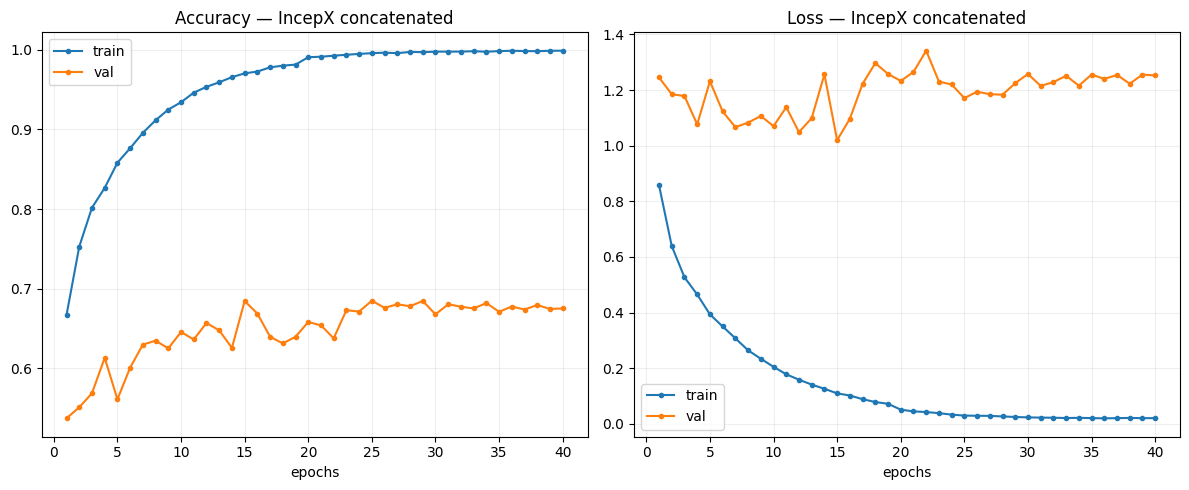

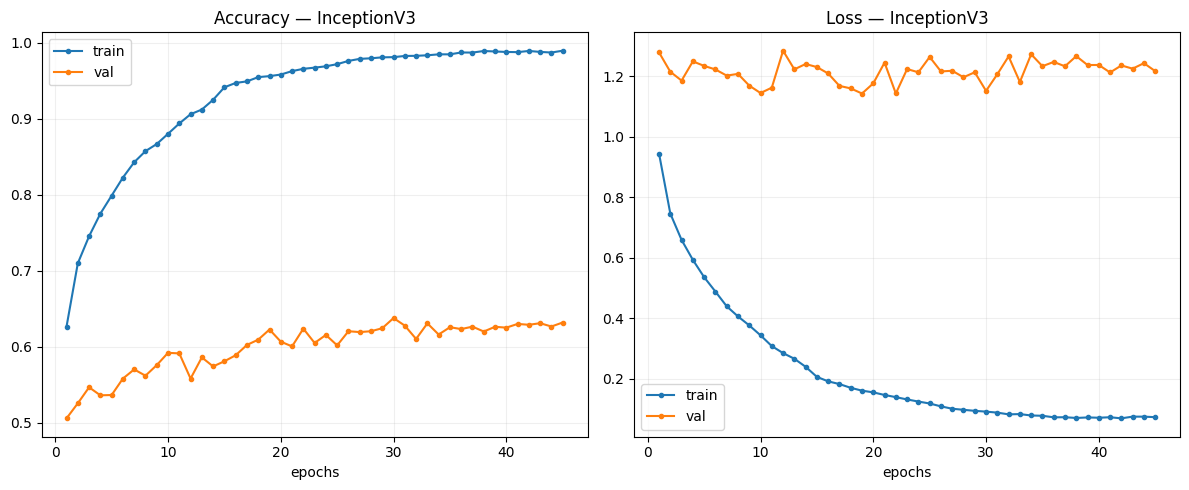

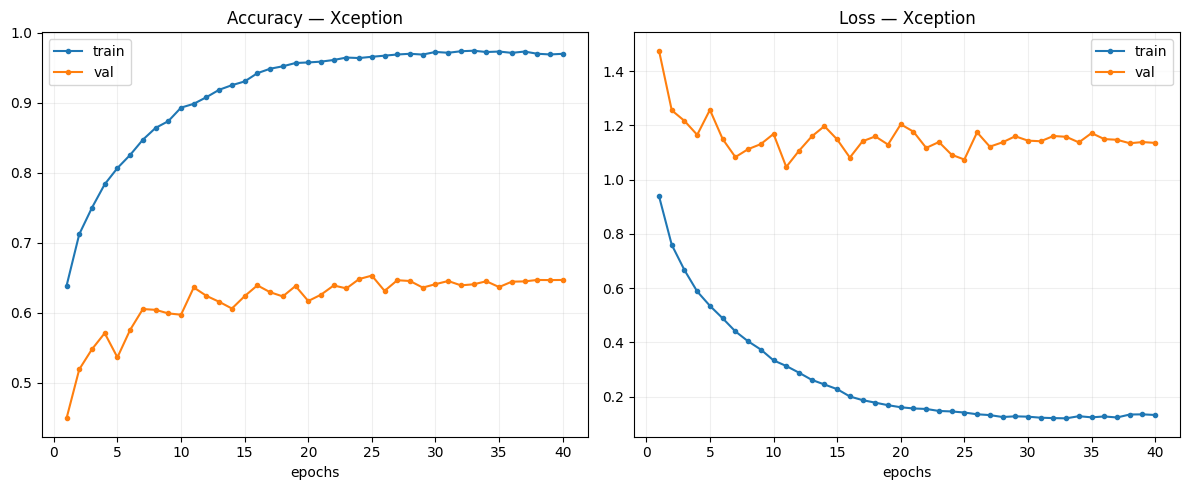

In [ ]:
import matplotlib.pyplot as plt

'''
_get: busca una metrica (key) dentro del dict h.history
  ENTRADA:
   h: objeto History devuelto por model.fit()
   key: nombre de la metrica a recuperar, puede ser 'accuracy' o 'loss'
  SALIDA:
    lista de valores de la metrica en cada epoca
    None si no se encuentra la metrica
'''

def _get(h, key):
    if key in h.history: return h.history[key]
    #versiones antiguas
    if key=='accuracy' and 'acc' in h.history: return h.history['acc']
    if key=='val_accuracy' and 'val_acc' in h.history: return h.history['val_acc']
    return None

'''
plot_history: grafica las curvas de entrenamiento y validacion de una metrica
  ENTRADA:
   h: objeto History devuelto por model.fit()
   title: titulo de la grafica
  SALIDA:
    grafica de entrenamiento y validacion de la metrica
'''

def plot_history(h, title):
    acc, vacc = _get(h, 'accuracy'), _get(h, 'val_accuracy')
    loss, vloss = _get(h, 'loss'), _get(h, 'val_loss')
    #secuencia de epocas
    ep = range(1, len(acc)+1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1); plt.plot(ep, acc, '.-', label='train'); plt.plot(ep, vacc, '.-', label='val')
    plt.title(f'Accuracy — {title}'); plt.xlabel('epochs'); plt.legend(); plt.grid(alpha=.2)
    plt.subplot(1,2,2); plt.plot(ep, loss, '.-', label='train'); plt.plot(ep, vloss, '.-', label='val')
    plt.title(f'Loss — {title}'); plt.xlabel('epochs'); plt.legend(); plt.grid(alpha=.2)
    plt.tight_layout(); plt.show()

plot_history(hist_concat, 'IncepX concatenated')
plot_history(history_inc, 'InceptionV3')
plot_history(history_xcp, 'Xception')

In [ ]:
#AUGMENT_TRAIN_ONLY

plot_history(hist_concat_noAug, 'IncepX concatenated')
plot_history(history_inc_noAug, 'InceptionV3')
plot_history(history_xcp_noAug, 'Xception')

#10. Matrices y ensemble ponderado

##10.1. Augment All

Ensemble ponderado → mejor w=0.4547 | F1-macro=0.6421 | Acc=0.6881
== InceptionV3 ==
              precision    recall  f1-score   support

          nv       0.62      0.88      0.73      1341
         mel       0.64      0.68      0.66      1338
         bkl       0.70      0.57      0.63      1314
         bcc       0.67      0.50      0.57       618
       akiec       0.53      0.33      0.41       396
        vasc       0.73      0.70      0.72       168
          df       0.67      0.29      0.40       138

    accuracy                           0.65      5313
   macro avg       0.65      0.56      0.59      5313
weighted avg       0.65      0.65      0.63      5313



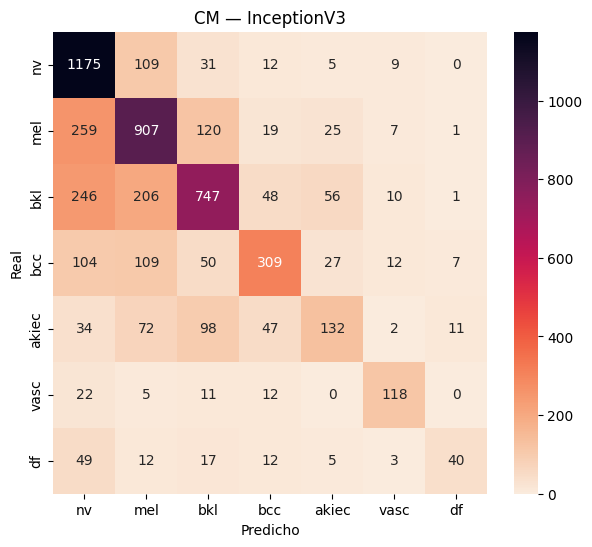

== Xception ==
              precision    recall  f1-score   support

          nv       0.64      0.89      0.75      1341
         mel       0.63      0.65      0.64      1338
         bkl       0.71      0.59      0.64      1314
         bcc       0.66      0.51      0.58       618
       akiec       0.53      0.40      0.46       396
        vasc       0.81      0.60      0.69       168
          df       0.68      0.33      0.44       138

    accuracy                           0.65      5313
   macro avg       0.67      0.57      0.60      5313
weighted avg       0.66      0.65      0.64      5313



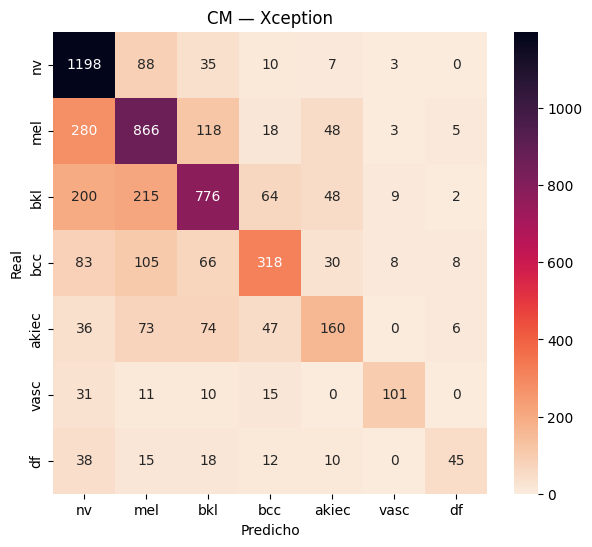

== Concatenado (IncepX Concat) ==
              precision    recall  f1-score   support

          nv       0.68      0.90      0.77      1341
         mel       0.72      0.68      0.70      1338
         bkl       0.70      0.70      0.70      1314
         bcc       0.72      0.54      0.62       618
       akiec       0.56      0.40      0.47       396
        vasc       0.86      0.66      0.75       168
          df       0.69      0.39      0.50       138

    accuracy                           0.70      5313
   macro avg       0.70      0.61      0.64      5313
weighted avg       0.70      0.70      0.69      5313



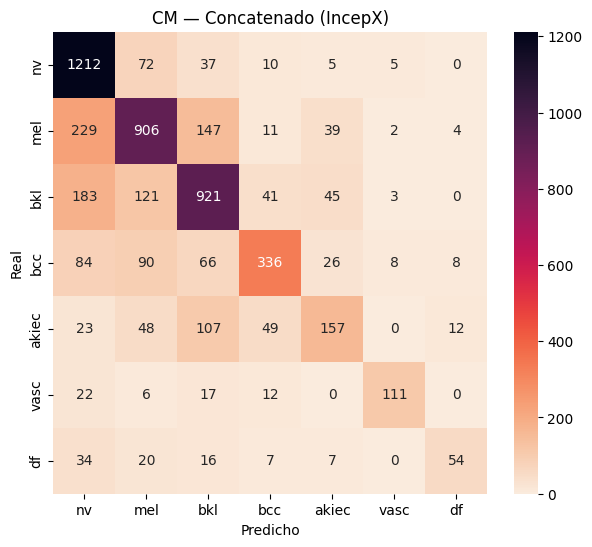

== Ensemble ponderado ==
              precision    recall  f1-score   support

          nv       0.66      0.90      0.76      1341
         mel       0.67      0.70      0.69      1338
         bkl       0.75      0.63      0.68      1314
         bcc       0.71      0.57      0.63       618
       akiec       0.56      0.39      0.46       396
        vasc       0.87      0.71      0.78       168
          df       0.77      0.35      0.48       138

    accuracy                           0.69      5313
   macro avg       0.71      0.61      0.64      5313
weighted avg       0.69      0.69      0.68      5313



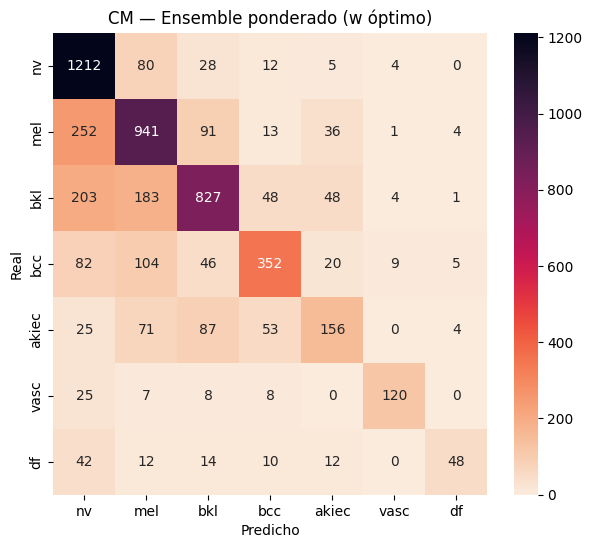

In [ ]:
import numpy as np, seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

# Probabilidades por clase para cada imagen
p_inc    = inception.predict(test_ds, verbose=0)
p_xcp    = xception.predict(test_ds,  verbose=0)
p_concat = concat_model.predict(test_ds, verbose=0)

# Etiquetas reales (one-hot -> indice)
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0).argmax(1)

# Ensemble ponderado

best = dict(w=None, f1=-1, acc=-1, preds=None)

for w in np.linspace(0, 1, 2000):
    p_final = w * p_inc + (1 - w) * p_xcp
    y_pred  = p_final.argmax(1)
    f1  = f1_score(y_true, y_pred, average='macro')
    acc = accuracy_score(y_true, y_pred)
    if f1 > best['f1']:
        best.update(w=w, f1=f1, acc=acc, preds=y_pred)

print(f"Ensemble ponderado → mejor w={best['w']:.4f} | "
      f"F1-macro={best['f1']:.4f} | Acc={best['acc']:.4f}")

# clases y funcion para matriz de confusion

ordered_classes = ['nv','mel','bkl','bcc','akiec','vasc','df']
label_map = {'akiec':0,'bcc':1,'bkl':2,'df':3,'mel':4,'nv':5,'vasc':6}
ordered_indices = [label_map[c] for c in ordered_classes]   # [5,4,2,1,0,6,3]

'''
plot_cm: calcula y visualiza la matriz de confusión entre etiquetas reales y predichas
  ENTRADA:
   y_true: lista con las etiquetas verdaderas (ground truth)
   y_pred: lista con las etiquetas predichas por el modelo
   title: cadena de texto (str) para el titulo
  SALIDA:
   Genera y muestra un gráfico de mapa de calor (heatmap) con la matriz de confusión
'''

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=ordered_indices)
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='rocket_r',
                xticklabels=ordered_classes, yticklabels=ordered_classes)
    plt.title(title)
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.show()

labels_order = ordered_indices

# Reportes y matrices de confusión

print("== InceptionV3 ==")
y_inc = p_inc.argmax(1)
print(classification_report(
    y_true, y_inc,
    labels=labels_order,
    target_names=ordered_classes
))
plot_cm(y_true, y_inc, "CM — InceptionV3")

print("== Xception ==")
y_xcp = p_xcp.argmax(1)
print(classification_report(
    y_true, y_xcp,
    labels=labels_order,
    target_names=ordered_classes
))
plot_cm(y_true, y_xcp, "CM — Xception")

print("== Concatenado (IncepX Concat) ==")
y_concat = p_concat.argmax(1)
print(classification_report(
    y_true, y_concat,
    labels=labels_order,
    target_names=ordered_classes
))
plot_cm(y_true, y_concat, "CM — Concatenado (IncepX)")

print("== Ensemble ponderado ==")
print(classification_report(
    y_true, best['preds'],
    labels=labels_order,
    target_names=ordered_classes
))
plot_cm(y_true, best['preds'], "CM — Ensemble ponderado (w óptimo)")

##10.2. AUGMENT_TRAIN_ONLY (fine-tuned)

[FT] Ensemble ponderado → mejor w=0.5008 | F1-macro=0.6987 | Acc=0.8542
== InceptionV3 (FT, train-only aug) ==
              precision    recall  f1-score   support

          nv       0.92      0.93      0.92      1341
         mel       0.61      0.64      0.62       223
         bkl       0.67      0.71      0.69       219
         bcc       0.74      0.66      0.70       103
       akiec       0.55      0.41      0.47        66
        vasc       0.75      0.75      0.75        28
          df       0.58      0.30      0.40        23

    accuracy                           0.83      2003
   macro avg       0.69      0.63      0.65      2003
weighted avg       0.83      0.83      0.83      2003



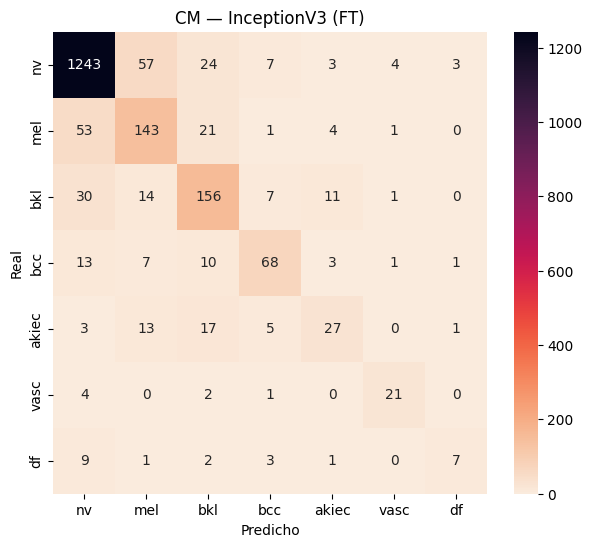

== Xception (FT, train-only aug) ==
              precision    recall  f1-score   support

          nv       0.92      0.93      0.92      1341
         mel       0.67      0.60      0.64       223
         bkl       0.64      0.68      0.66       219
         bcc       0.68      0.67      0.68       103
       akiec       0.50      0.52      0.51        66
        vasc       0.92      0.79      0.85        28
          df       0.59      0.43      0.50        23

    accuracy                           0.83      2003
   macro avg       0.70      0.66      0.68      2003
weighted avg       0.83      0.83      0.83      2003



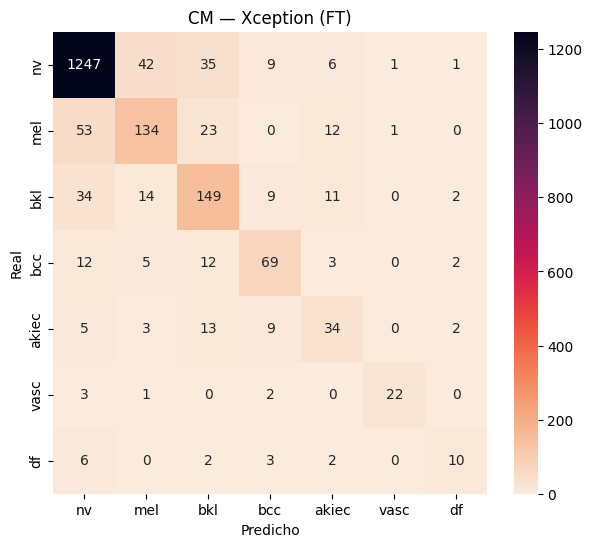

== Concatenado IncepX (FT, train-only aug) ==
              precision    recall  f1-score   support

          nv       0.92      0.93      0.92      1341
         mel       0.62      0.63      0.63       223
         bkl       0.65      0.69      0.67       219
         bcc       0.73      0.64      0.68       103
       akiec       0.55      0.44      0.49        66
        vasc       0.79      0.68      0.73        28
          df       0.60      0.39      0.47        23

    accuracy                           0.83      2003
   macro avg       0.69      0.63      0.66      2003
weighted avg       0.83      0.83      0.83      2003



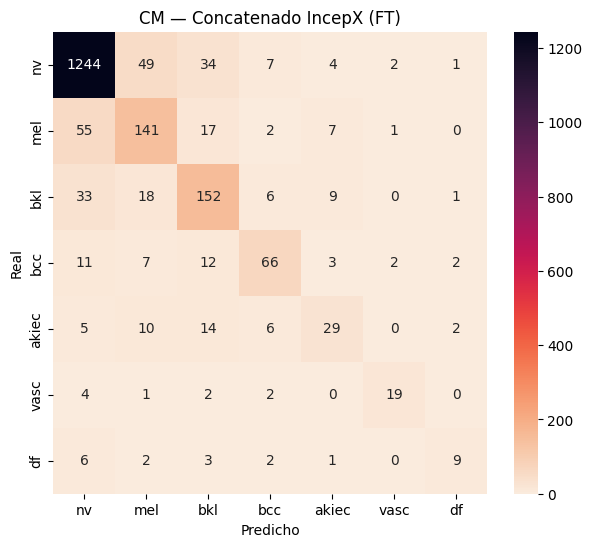

== Ensemble ponderado (Inception FT + Xception FT) ==
              precision    recall  f1-score   support

          nv       0.92      0.94      0.93      1341
         mel       0.71      0.65      0.68       223
         bkl       0.71      0.74      0.72       219
         bcc       0.74      0.73      0.73       103
       akiec       0.54      0.50      0.52        66
        vasc       0.88      0.79      0.83        28
          df       0.60      0.39      0.47        23

    accuracy                           0.85      2003
   macro avg       0.73      0.68      0.70      2003
weighted avg       0.85      0.85      0.85      2003



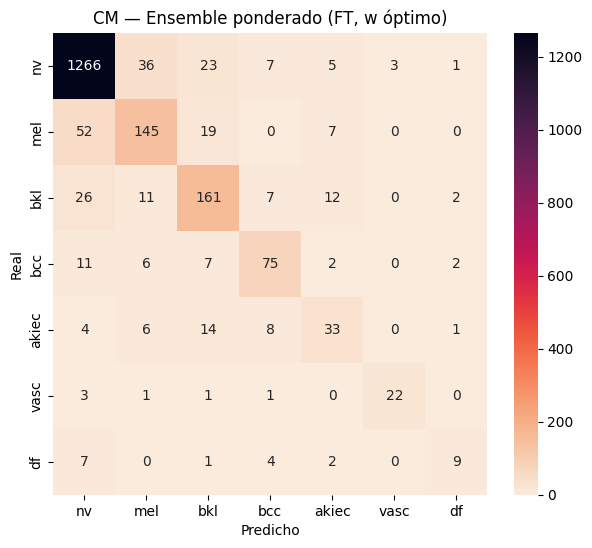

In [ ]:
import numpy as np, seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

# Probabilidades por clase para cada imagen (train aumentado)

p_inc_ft    = inception_noAug_ft.predict(test_ds_noAug, verbose=0)
p_xcp_ft    = xception_noAug_ft.predict(test_ds_noAug,  verbose=0)
p_concat_ft = concat_model_noAug_ft.predict(test_ds_noAug, verbose=0)

# Etiquetas reales (one-hot -> indice)
y_true_ft = np.concatenate([y.numpy() for _, y in test_ds_noAug], axis=0).argmax(1)

# Ensemble ponderado

best_ft = dict(w=None, f1=-1, acc=-1, preds=None)

for w in np.linspace(0, 1, 2000):
    p_final_ft = w * p_inc_ft + (1 - w) * p_xcp_ft
    y_pred_ft  = p_final_ft.argmax(1)
    f1 = f1_score(y_true_ft, y_pred_ft, average='macro')
    acc = accuracy_score(y_true_ft, y_pred_ft)
    if f1 > best_ft['f1']:
        best_ft.update(w=w, f1=f1, acc=acc, preds=y_pred_ft)

print(f"[FT] Ensemble ponderado → mejor w={best_ft['w']:.4f} | "
      f"F1-macro={best_ft['f1']:.4f} | Acc={best_ft['acc']:.4f}")

# clases y funcion para matriz de confusion

ordered_classes = ['nv','mel','bkl','bcc','akiec','vasc','df']
label_map = {'akiec':0,'bcc':1,'bkl':2,'df':3,'mel':4,'nv':5,'vasc':6}
ordered_indices = [label_map[c] for c in ordered_classes]

def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred, labels=ordered_indices)
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='rocket_r',
                xticklabels=ordered_classes, yticklabels=ordered_classes)
    plt.title(title)
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.show()

class_names = [c for c in ordered_classes]

# Reportes y matrices de confusión

labels_order = [label_map[c] for c in ordered_classes]  # [5,4,2,1,0,6,3]

print("== InceptionV3 (FT, train-only aug) ==")
y_inc_ft = p_inc_ft.argmax(1)
print(classification_report(
    y_true_ft,
    y_inc_ft,
    labels=labels_order,
    target_names=ordered_classes
))
plot_cm(y_true_ft, y_inc_ft, "CM — InceptionV3 (FT)")

print("== Xception (FT, train-only aug) ==")
y_xcp_ft = p_xcp_ft.argmax(1)
print(classification_report(
    y_true_ft,
    y_xcp_ft,
    labels=labels_order,
    target_names=ordered_classes
))
plot_cm(y_true_ft, y_xcp_ft, "CM — Xception (FT)")

print("== Concatenado IncepX (FT, train-only aug) ==")
y_concat_ft = p_concat_ft.argmax(1)
print(classification_report(
    y_true_ft,
    y_concat_ft,
    labels=labels_order,
    target_names=ordered_classes
))
plot_cm(y_true_ft, y_concat_ft, "CM — Concatenado IncepX (FT)")

print("== Ensemble ponderado (Inception FT + Xception FT) ==")
print(classification_report(
    y_true_ft,
    best_ft['preds'],
    labels=labels_order,
    target_names=ordered_classes
))
plot_cm(y_true_ft, best_ft['preds'], "CM — Ensemble ponderado (FT, w óptimo)")

#11. Curva ROC

##11.1. AUGMENT_ALL

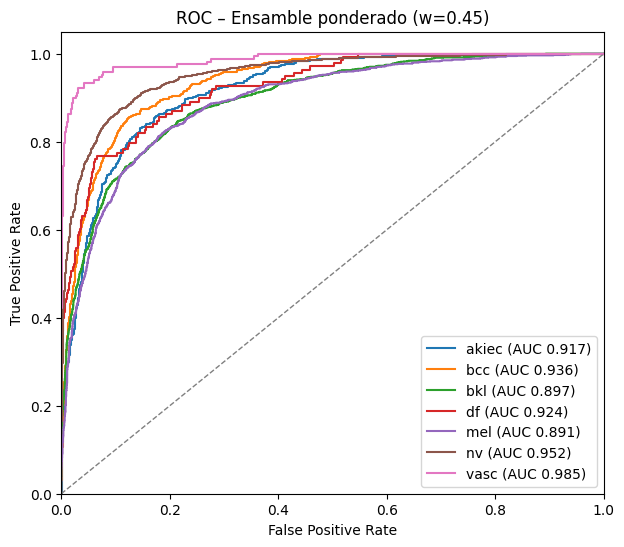

AUCs por clase: {'akiec': '0.917', 'bcc': '0.936', 'bkl': '0.897', 'df': '0.924', 'mel': '0.891', 'nv': '0.952', 'vasc': '0.985'}
AUC micro: 0.936 | AUC macro: 0.929


In [ ]:
# ROC del ensemble (aumentar todos los conjuntos)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# y_true (integers) one-hot para ROC one-vs-rest
y_true_oh = tf.one_hot(y_true, NUM_CLASSES).numpy()

# peso optimo
w = best['w']
if w is None:
    raise ValueError("No hay peso óptimo en 'best'. Asegúrate de haber corrido el grid search antes.")

# Ensemble: prob_final = w * Inception + (1-w) * Xception
probs_best = w * p_inc + (1.0 - w) * p_xcp

# ROC por clase
plt.figure(figsize=(7,6))
aucs = [] #lista de AUC individuales por clase
for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_true_oh[:, i], probs_best[:, i])
    roc_auc = auc(fpr, tpr) #AUC de la clase
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, label=f"{id2name[i]} (AUC {roc_auc:.3f})")
plt.plot([0,1], [0,1], '--', lw=1, color='gray')
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title(f'ROC – Ensamble ponderado (w={w:.2f})')
plt.legend(loc='lower right')
plt.show()

print("AUCs por clase:", {id2name[i]: f"{aucs[i]:.3f}" for i in range(NUM_CLASSES)})

# micro y macro ROC
from sklearn.preprocessing import label_binarize
# micro-ROC (rendimiento global sin importar clases)
fpr_micro, tpr_micro, _ = roc_curve(y_true_oh.ravel(), probs_best.ravel())
auc_micro = auc(fpr_micro, tpr_micro)

# macro-ROC (promedio de AUCs por clase) (calidad media de discriminacion del modelo)
# da igua peso a cada clase, aunque sea minoritaria
auc_macro = np.mean(aucs)
print(f"AUC micro: {auc_micro:.3f} | AUC macro: {auc_macro:.3f}")

##11.2. AUGMENT_TRAIN_ONLY (fine-tuned)

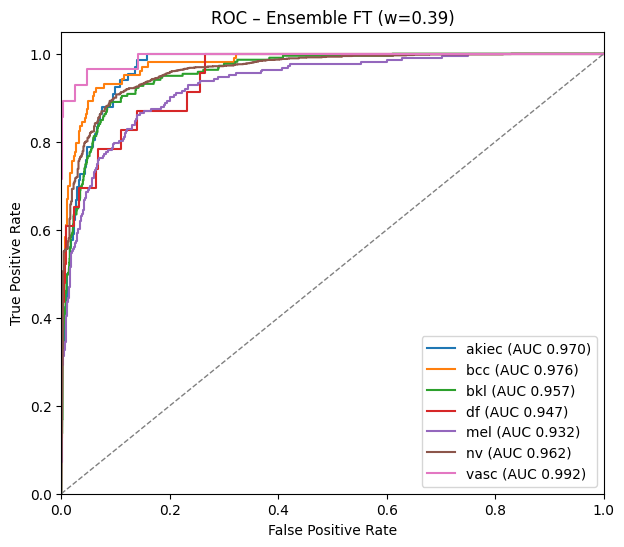

AUCs por clase (FT):
{'akiec': '0.970', 'bcc': '0.976', 'bkl': '0.957', 'df': '0.947', 'mel': '0.932', 'nv': '0.962', 'vasc': '0.992'}
AUC micro (FT): 0.983 | AUC macro (FT): 0.962


In [ ]:
# ROC del ensemble (aumentar solo train)

# Probabilidades
p_inc_ft    = inception_noAug_ft.predict(test_ds_noAug, verbose=0)
p_xcp_ft    = xception_noAug_ft.predict(test_ds_noAug,  verbose=0)

# Etiquetas reales en entero
y_true_ft = np.concatenate([y.numpy() for _, y in test_ds_noAug], axis=0).argmax(1)

# One-hot para ROC one-vs-rest
y_true_ft_oh = tf.one_hot(y_true_ft, NUM_CLASSES).numpy()

# peso optimo (ft)
w_ft = best_ft["w"]
if w_ft is None:
    raise ValueError("Primero corre el grid search FT para obtener best_ft['w'].")

# Ensemble FT: prob_final = w * Inception + (1-w) * Xception
probs_best_ft = w_ft * p_inc_ft + (1.0 - w_ft) * p_xcp_ft

# ROC por clase
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(7,6))
aucs_ft = []

for i in range(NUM_CLASSES):
    fpr, tpr, _ = roc_curve(y_true_ft_oh[:, i], probs_best_ft[:, i])
    roc_auc = auc(fpr, tpr)
    aucs_ft.append(roc_auc)
    plt.plot(fpr, tpr, label=f"{id2name[i]} (AUC {roc_auc:.3f})")

plt.plot([0,1], [0,1], '--', lw=1, color='gray')
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC – Ensemble FT (w={w_ft:.2f})')
plt.legend(loc='lower right')
plt.show()

print("AUCs por clase (FT):")
print({id2name[i]: f"{aucs_ft[i]:.3f}" for i in range(NUM_CLASSES)})

# ROC micro y macro

# Micro-ROC
fpr_micro_ft, tpr_micro_ft, _ = roc_curve(y_true_ft_oh.ravel(), probs_best_ft.ravel())
auc_micro_ft = auc(fpr_micro_ft, tpr_micro_ft)

# Macro-ROC
auc_macro_ft = np.mean(aucs_ft)

print(f"AUC micro (FT): {auc_micro_ft:.3f} | AUC macro (FT): {auc_macro_ft:.3f}")
